<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/6_TrainLayersSeparately.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [1]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [3]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.9MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




Mô hình ban đầu gồm 7 layer sau đó sẽ được chia thành 4 mô hình con với số lượng layer là  2:2:2:1

In [5]:
class MLP_1layer(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_1layer, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    # don't have output
    #self.output = nn.Linear(hidden_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.05)
        nn.init.constant_(module.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = nn.Sigmoid()(x)

    # don't have output
    #output = self.output(x) # don't have output

    return x

In [6]:
class MLP_2layers(nn.Module):
  def __init__(self, input_dims, output_dims):
    super(MLP_2layers, self).__init__()
    self.layer1 = nn.Linear(input_dims, output_dims)
    self.layer2 = nn.Linear(output_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.05)
        nn.init.constant_(module.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)

    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)

    return x


In [7]:
input_dims = 784 #28x28 pixel = 784 pixel
output_dims = 128

# Khởi tạo các module thành phần, ở mạng này ta có 4 module thành phần theo tỷ lệ 2:2:2:1
first = MLP_2layers(input_dims, output_dims)
second = MLP_2layers(output_dims, output_dims)
third = MLP_2layers(output_dims, output_dims)
fourth = MLP_1layer(output_dims, output_dims)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

Training function

In [8]:
def train_model(model, optimizer, epochs=100):
  train_loss_list = []
  val_loss_list = []
  train_acc_list = []
  val_acc_list = []

  for epoch in range(epochs):
    #train
    train_loss = 0.0
    train_acc = 0.0
    num_sample = 0

    model.train()
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      y_predict = model(X_train)

      loss = criterion(y_predict, y_train)
      loss.backward()

      optimizer.step()

      train_loss += loss.item()
      train_acc += (torch.argmax(y_predict, dim=1) == y_train).sum().item()
      num_sample += len(y_train)

    train_loss /= len(train_loader)
    train_acc /= num_sample
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    #evaluation
    val_loss = 0.0
    val_acc = 0.0
    num_sample = 0

    model.eval()
    with torch.no_grad():
      for X_val, y_val in val_loader:
       X_val, y_val = X_val.to(device), y_val.to(device)

       y_predict = model(X_val)

       loss = criterion(y_predict, y_val)

       val_loss += loss.item()
       val_acc += (torch.argmax(y_predict, dim=1) == y_val).sum().item()
       num_sample += len(y_val)

    val_loss /= len(val_loader)
    val_acc /= num_sample
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: \
    Train loss: {train_loss:.4f}, \
    Train accuracy: {train_acc:.4f} \
    Validation loss: {val_loss:.4f} \
    Validation accuracy: {val_acc:.4f}")

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list



Visualization funciton

In [9]:
def visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
  fig, ax = plt.subplots(2, 2, figsize=(12,10))

  ax[0,0].plot(train_loss_list, color='green')
  ax[0,0].set(title='Train Loss', xlabel='Epoch', ylabel='Loss')

  ax[0,1].plot(train_acc_list, color='green')
  ax[0,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  ax[1,0].plot(val_loss_list, color='orange')
  ax[1,0].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

  ax[1,1].plot(val_acc_list, color='orange')
  ax[1,1].set(title='Train Accuracy', xlabel='Epoch', ylabel='Accuracy')

  plt.show()


## **3. Training 1**

In [10]:
# initialize
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [11]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 2.2945,     Train accuracy: 0.1334     Validation loss: 2.2802     Validation accuracy: 0.2598
Epoch 2/100:     Train loss: 2.2586,     Train accuracy: 0.2578     Validation loss: 2.2265     Validation accuracy: 0.3155
Epoch 3/100:     Train loss: 2.1496,     Train accuracy: 0.3626     Validation loss: 2.0360     Validation accuracy: 0.4390
Epoch 4/100:     Train loss: 1.8703,     Train accuracy: 0.4302     Validation loss: 1.7300     Validation accuracy: 0.3747
Epoch 5/100:     Train loss: 1.6135,     Train accuracy: 0.4995     Validation loss: 1.5219     Validation accuracy: 0.5190
Epoch 6/100:     Train loss: 1.4266,     Train accuracy: 0.5530     Validation loss: 1.3559     Validation accuracy: 0.5510
Epoch 7/100:     Train loss: 1.2782,     Train accuracy: 0.5857     Validation loss: 1.2293     Validation accuracy: 0.5982
Epoch 8/100:     Train loss: 1.1682,     Train accuracy: 0.6079     Validation loss: 1.1360     Validation accuracy: 0.6160
Epoch 9/

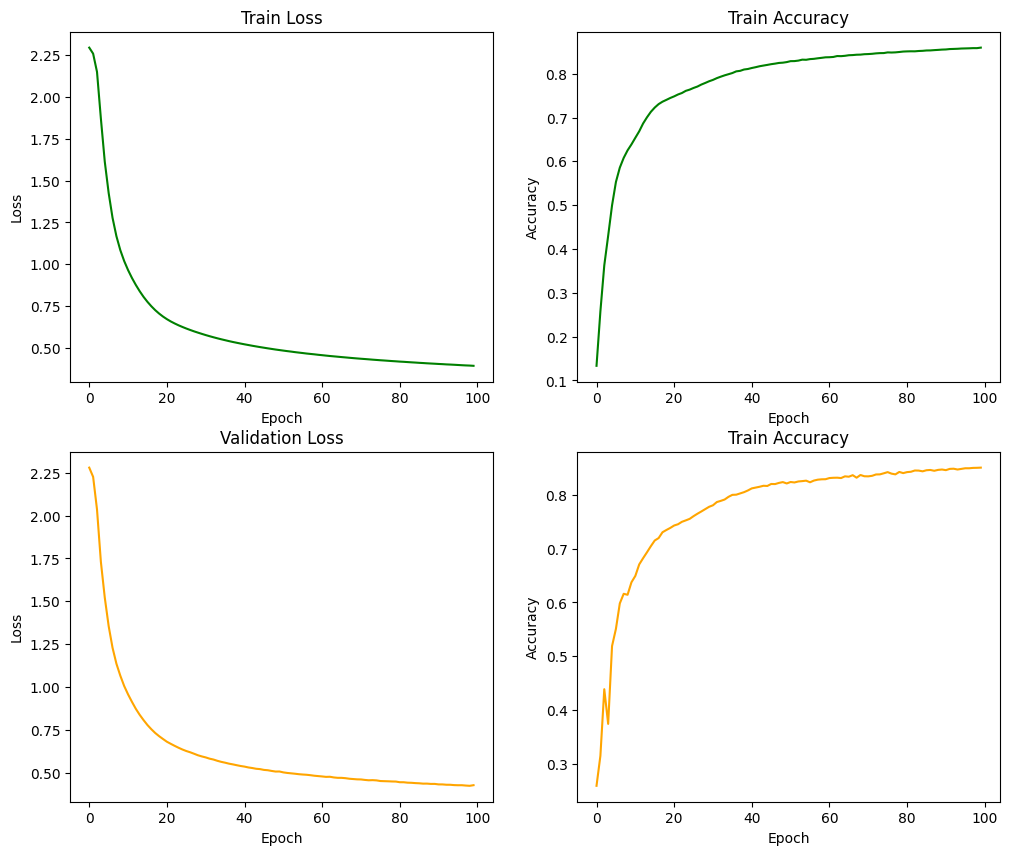

In [12]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **4. Training 2**

In [13]:
# initialize
# first được giữ cố dịnh, không cập nhật trọng số
for param in first.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [14]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 2.3017,     Train accuracy: 0.1086     Validation loss: 2.2998     Validation accuracy: 0.1020
Epoch 2/100:     Train loss: 2.2964,     Train accuracy: 0.1273     Validation loss: 2.2936     Validation accuracy: 0.1003
Epoch 3/100:     Train loss: 2.2885,     Train accuracy: 0.1595     Validation loss: 2.2826     Validation accuracy: 0.2685
Epoch 4/100:     Train loss: 2.2725,     Train accuracy: 0.1969     Validation loss: 2.2592     Validation accuracy: 0.3448
Epoch 5/100:     Train loss: 2.2310,     Train accuracy: 0.2619     Validation loss: 2.1919     Validation accuracy: 0.2758
Epoch 6/100:     Train loss: 2.1070,     Train accuracy: 0.2966     Validation loss: 1.9988     Validation accuracy: 0.3737
Epoch 7/100:     Train loss: 1.8697,     Train accuracy: 0.3563     Validation loss: 1.7642     Validation accuracy: 0.4423
Epoch 8/100:     Train loss: 1.6900,     Train accuracy: 0.4424     Validation loss: 1.6392     Validation accuracy: 0.5558
Epoch 9/

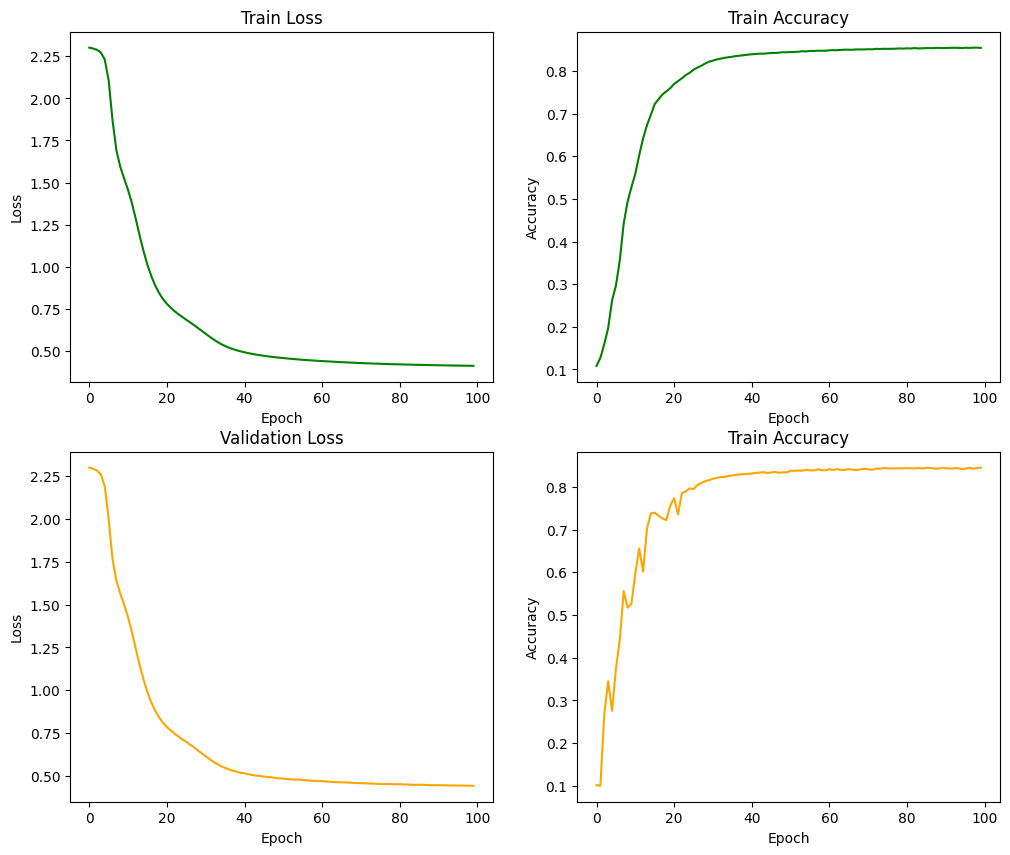

In [15]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **5. Training 3**

In [16]:
# initialize
# huấn luyện lại toàn bộ mạng hiện có mà không cố định thành phần nào
for param in first.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [17]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 1.3180,     Train accuracy: 0.7646     Validation loss: 0.8822     Validation accuracy: 0.8055
Epoch 2/100:     Train loss: 0.7278,     Train accuracy: 0.8311     Validation loss: 0.6497     Validation accuracy: 0.8285
Epoch 3/100:     Train loss: 0.5834,     Train accuracy: 0.8380     Validation loss: 0.5659     Validation accuracy: 0.8313
Epoch 4/100:     Train loss: 0.5221,     Train accuracy: 0.8415     Validation loss: 0.5235     Validation accuracy: 0.8357
Epoch 5/100:     Train loss: 0.4889,     Train accuracy: 0.8453     Validation loss: 0.4980     Validation accuracy: 0.8398
Epoch 6/100:     Train loss: 0.4682,     Train accuracy: 0.8475     Validation loss: 0.4853     Validation accuracy: 0.8405
Epoch 7/100:     Train loss: 0.4539,     Train accuracy: 0.8503     Validation loss: 0.4715     Validation accuracy: 0.8438
Epoch 8/100:     Train loss: 0.4435,     Train accuracy: 0.8518     Validation loss: 0.4627     Validation accuracy: 0.8435
Epoch 9/

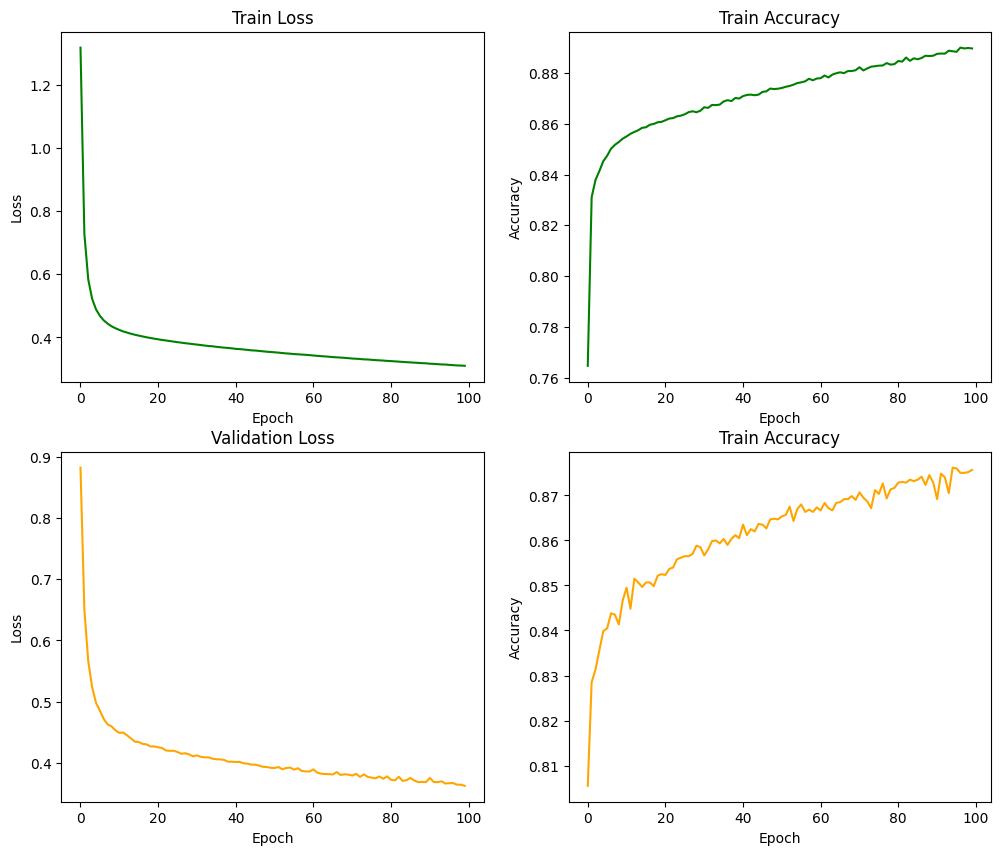

In [18]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **6. Training 4**


In [19]:
# initialize
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [20]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 2.2989,     Train accuracy: 0.1186     Validation loss: 2.2946     Validation accuracy: 0.1033
Epoch 2/100:     Train loss: 2.2872,     Train accuracy: 0.1646     Validation loss: 2.2803     Validation accuracy: 0.2682
Epoch 3/100:     Train loss: 2.2646,     Train accuracy: 0.2394     Validation loss: 2.2444     Validation accuracy: 0.2657
Epoch 4/100:     Train loss: 2.1989,     Train accuracy: 0.3184     Validation loss: 2.1322     Validation accuracy: 0.4170
Epoch 5/100:     Train loss: 2.0017,     Train accuracy: 0.3697     Validation loss: 1.8577     Validation accuracy: 0.3822
Epoch 6/100:     Train loss: 1.7331,     Train accuracy: 0.4964     Validation loss: 1.6393     Validation accuracy: 0.5992
Epoch 7/100:     Train loss: 1.5626,     Train accuracy: 0.6154     Validation loss: 1.4998     Validation accuracy: 0.6772
Epoch 8/100:     Train loss: 1.4255,     Train accuracy: 0.6817     Validation loss: 1.3608     Validation accuracy: 0.7087
Epoch 9/

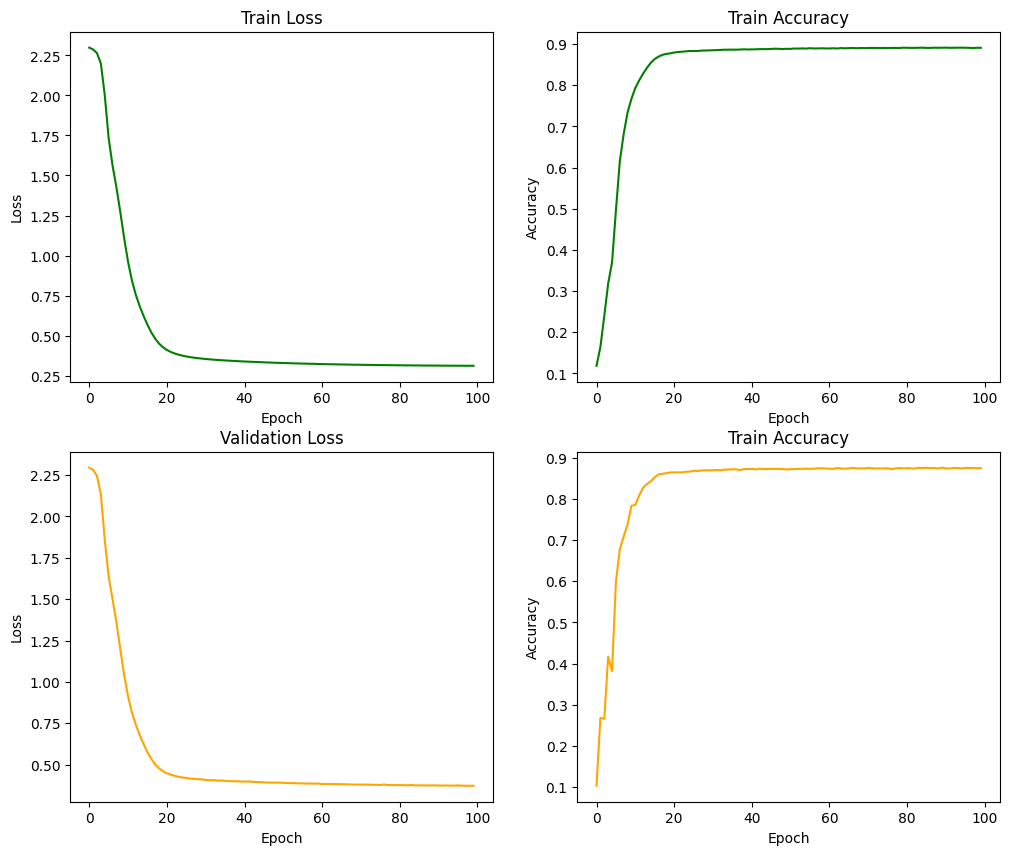

In [21]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **7. Training 5**


In [22]:
for param in first.parameters():
  param.requires_grad = True
for param in second.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [23]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 1.2018,     Train accuracy: 0.8109     Validation loss: 0.7318     Validation accuracy: 0.8643
Epoch 2/100:     Train loss: 0.5741,     Train accuracy: 0.8781     Validation loss: 0.5166     Validation accuracy: 0.8640
Epoch 3/100:     Train loss: 0.4445,     Train accuracy: 0.8820     Validation loss: 0.4503     Validation accuracy: 0.8673
Epoch 4/100:     Train loss: 0.3946,     Train accuracy: 0.8847     Validation loss: 0.4222     Validation accuracy: 0.8695
Epoch 5/100:     Train loss: 0.3697,     Train accuracy: 0.8849     Validation loss: 0.4047     Validation accuracy: 0.8717
Epoch 6/100:     Train loss: 0.3543,     Train accuracy: 0.8864     Validation loss: 0.3951     Validation accuracy: 0.8725
Epoch 7/100:     Train loss: 0.3447,     Train accuracy: 0.8871     Validation loss: 0.3933     Validation accuracy: 0.8728
Epoch 8/100:     Train loss: 0.3380,     Train accuracy: 0.8878     Validation loss: 0.3851     Validation accuracy: 0.8742
Epoch 9/

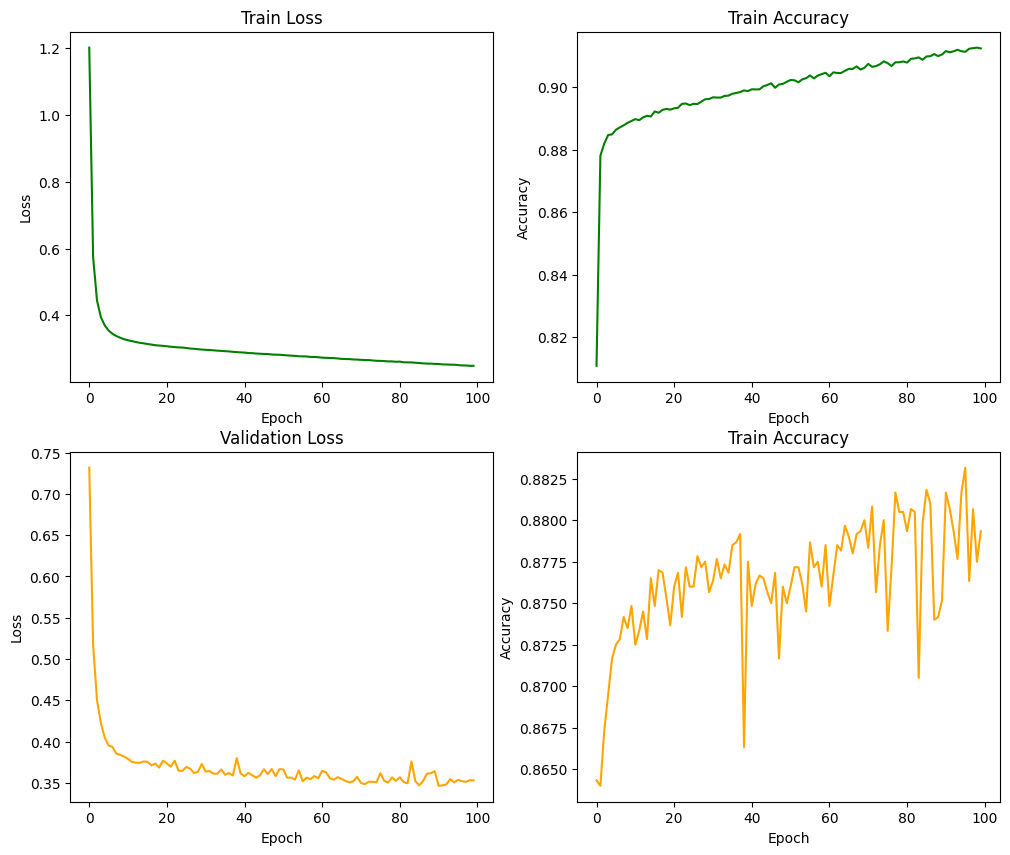

In [24]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **8. Training 6**


In [25]:
for param in first.parameters():
  param.requires_grad = False
for param in second.parameters():
  param.requires_grad = False
for param in third.parameters():
  param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [26]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 2.1316,     Train accuracy: 0.5574     Validation loss: 1.8846     Validation accuracy: 0.7420
Epoch 2/100:     Train loss: 1.5304,     Train accuracy: 0.8654     Validation loss: 1.2168     Validation accuracy: 0.8680
Epoch 3/100:     Train loss: 0.9549,     Train accuracy: 0.9027     Validation loss: 0.7840     Validation accuracy: 0.8760
Epoch 4/100:     Train loss: 0.6276,     Train accuracy: 0.9084     Validation loss: 0.5724     Validation accuracy: 0.8805
Epoch 5/100:     Train loss: 0.4694,     Train accuracy: 0.9115     Validation loss: 0.4741     Validation accuracy: 0.8807
Epoch 6/100:     Train loss: 0.3901,     Train accuracy: 0.9130     Validation loss: 0.4249     Validation accuracy: 0.8802
Epoch 7/100:     Train loss: 0.3461,     Train accuracy: 0.9139     Validation loss: 0.3972     Validation accuracy: 0.8815
Epoch 8/100:     Train loss: 0.3193,     Train accuracy: 0.9142     Validation loss: 0.3807     Validation accuracy: 0.8823
Epoch 9/

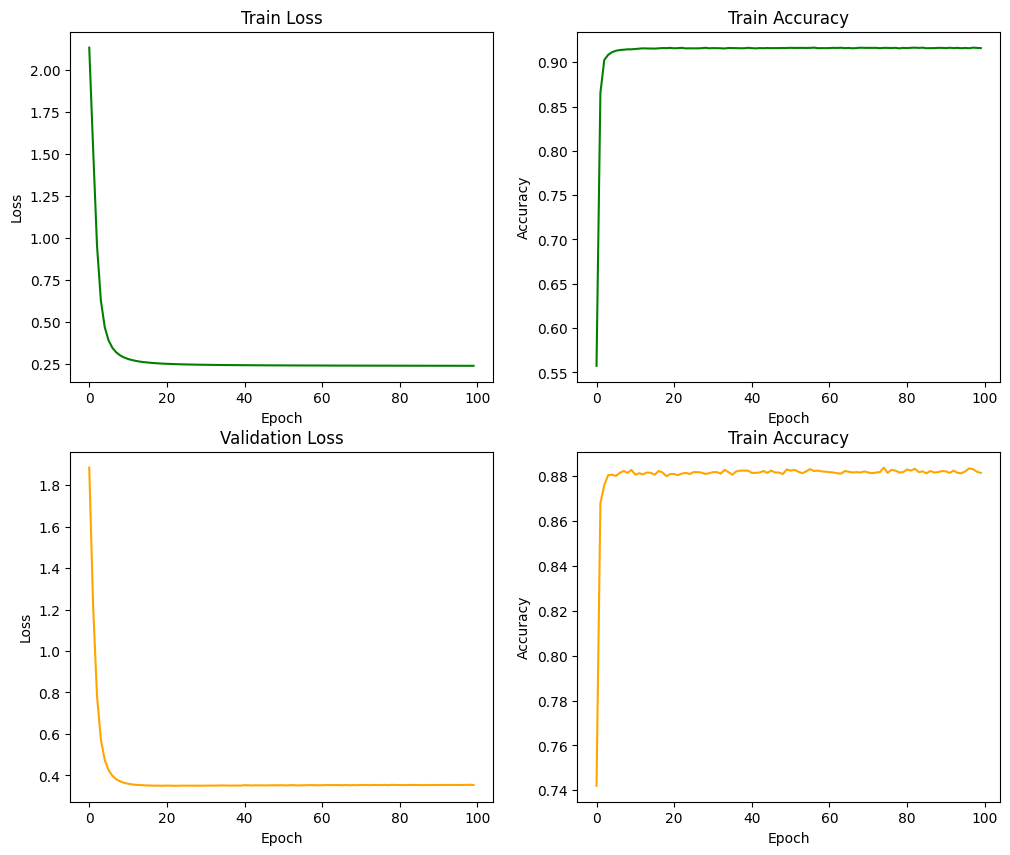

In [27]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **8. Training 7**

In [28]:
for param in first.parameters():
  param.requires_grad = True
for param in second.parameters():
  param.requires_grad = True
for param in third.parameters():
  param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
print(f"model parameters = {model.parameters()}")

model parameters = <generator object Module.parameters at 0x7a002b34ba00>


In [29]:
# training code
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(model, optimizer, epochs=100)

Epoch 1/100:     Train loss: 1.0349,     Train accuracy: 0.8596     Validation loss: 0.5914     Validation accuracy: 0.8788
Epoch 2/100:     Train loss: 0.4439,     Train accuracy: 0.9055     Validation loss: 0.4350     Validation accuracy: 0.8785
Epoch 3/100:     Train loss: 0.3468,     Train accuracy: 0.9083     Validation loss: 0.3932     Validation accuracy: 0.8782
Epoch 4/100:     Train loss: 0.3104,     Train accuracy: 0.9097     Validation loss: 0.3749     Validation accuracy: 0.8797
Epoch 5/100:     Train loss: 0.2920,     Train accuracy: 0.9114     Validation loss: 0.3690     Validation accuracy: 0.8797
Epoch 6/100:     Train loss: 0.2809,     Train accuracy: 0.9118     Validation loss: 0.3637     Validation accuracy: 0.8810
Epoch 7/100:     Train loss: 0.2741,     Train accuracy: 0.9119     Validation loss: 0.3538     Validation accuracy: 0.8810
Epoch 8/100:     Train loss: 0.2690,     Train accuracy: 0.9111     Validation loss: 0.3609     Validation accuracy: 0.8773
Epoch 9/

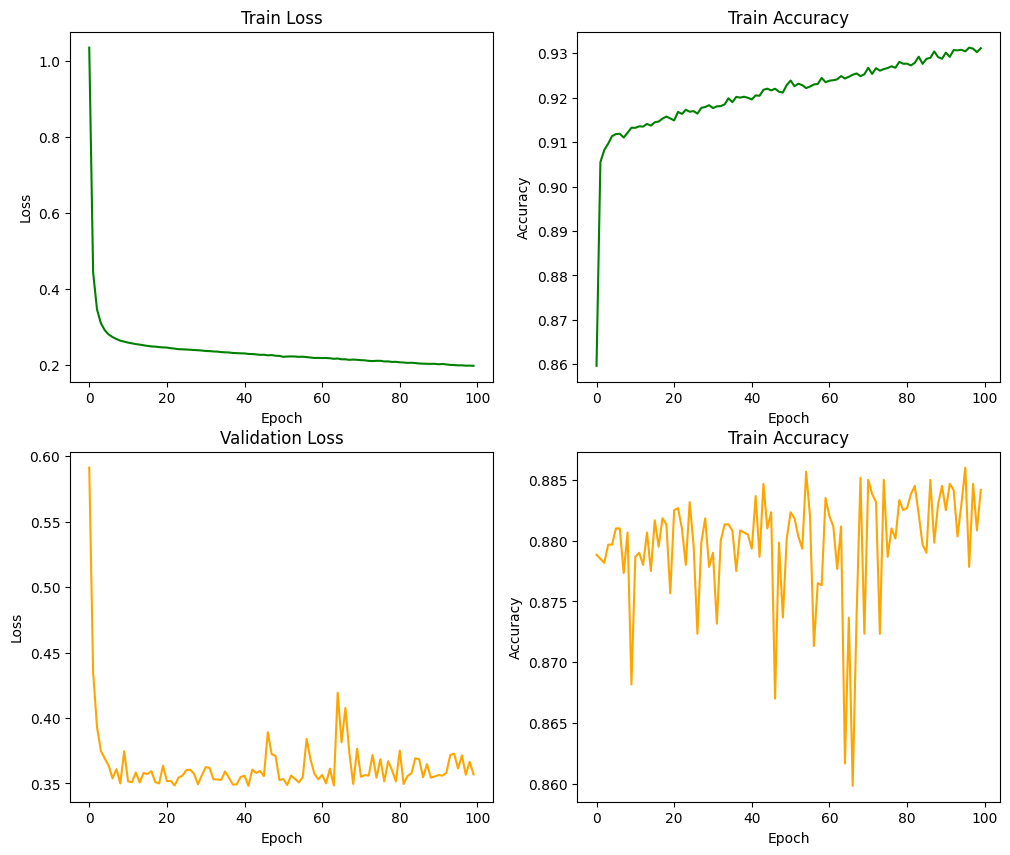

In [30]:
visualization_train(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

## **10. Evaluation**

In [31]:
test_label = []
test_predict = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    output = model(X_test)

    # transfer to CPU, currently it is tensor
    test_label.append(y_test.cpu())
    test_predict.append(output.cpu())

  test_label = torch.cat(test_label, dim=0)
  test_predict = torch.cat(test_predict, dim=0)
  test_acc = (torch.argmax(test_predict, dim=1) == test_label).sum().item()/len(test_label)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.8756


In [32]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    # transfer to CP, currently it is tensor
    val_label.append(y_val.cpu())
    val_predict.append(output.cpu())

  val_label = torch.cat(val_label, dim=0)
  val_predict = torch.cat(val_predict, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item()/len(val_label)

print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.8842
